In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Data

In [ ]:
data_list = []
for i in range(0, 27):
    df = pd.read_csv(f"data/aggregated_individual_data_interpolation/interpolation/{i}_interpolated.csv",
                     index_col=0)
    df = pd.read_csv(f"data/aggregated_individual_data_interpolation/interpolation/{i}_interpolated.csv",
                     index_col=0)
    df["subject_id"] = i + 1
    data_list.append(df)

# Concatenate the data into a single dataset
data = pd.concat(data_list)
data.drop(["circumplex.arousal_std", "circumplex.valence_std", "mood_std", "activity_std"], inplace=True, axis=1)



data.drop(["date"], inplace=True, axis=1)
df = data

df.reset_index(inplace=True, drop=True)
df = df.astype({'subject_id': 'float64', 'days': 'float64', 'weekday': 'float64'})
df = data

Model

In [5]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
              'activity', 'screen', 'call', 'sms', 'appCat.builtin',
              'appCat.communication', 'appCat.entertainment', 'appCat.finance',
              'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
              'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days'  # always correct
IN_STEPS = 14  # use 7 days
OUT_STEPS = 1  # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

test_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)

test_window.update_datasets(train_series, val_series, test_series, norm=True)
# print(test_window.test_df)
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

history = compile_and_fit(lstm_model, test_window)
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(test_window.val)
performance['LSTM'] = lstm_model.evaluate(test_window.test, verbose=0)


2023-04-11 16:01:08.136233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
85/85 [==============================] - 9s 34ms/step - loss: 1.1481 - mean_absolute_error: 0.8827 - val_loss: 2.1283 - val_mean_absolute_error: 1.2334
Epoch 2/20
85/85 [==============================] - 2s 17ms/step - loss: 1.0125 - mean_absolute_error: 0.8238 - val_loss: 2.0946 - val_mean_absolute_error: 1.2030
Epoch 3/20
85/85 [==============================] - 2s 17ms/step - loss: 0.9506 - mean_absolute_error: 0.7798 - val_loss: 2.0068 - val_mean_absolute_error: 1.1616
Epoch 4/20
85/85 [==============================] - 2s 19ms/step - loss: 0.8831 - mean_absolute_error: 0.7428 - val_loss: 1.8700 - val_mean_absolute_error: 1.1315
Epoch 5/20
85/85 [==============================] - 2s 17ms/step - loss: 0.8248 - mean_absolute_error: 0.7154 - val_loss: 1.9982 - val_mean_absolute_error: 1.1517
Epoch 6/20
51/51 [==============================] - 1s 3ms/step - loss: 1.9613 - mean_absolute_error: 1.1351


In [14]:
def plot(self, model=None, plot_col=None, max_subplots=3):
        inputs, labels = self.example
        if not plot_col:
            plot_col = self.LABELS[0]
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                print(self.label_indices.shape, predictions[n, :, label_col_index].shape)
                print(predictions[n, :, label_col_index])
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [Days]')
        plt.show()


In [26]:
def plot_2(self, model=None, plot_col='mood', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

ValueError: x and y must be the same size

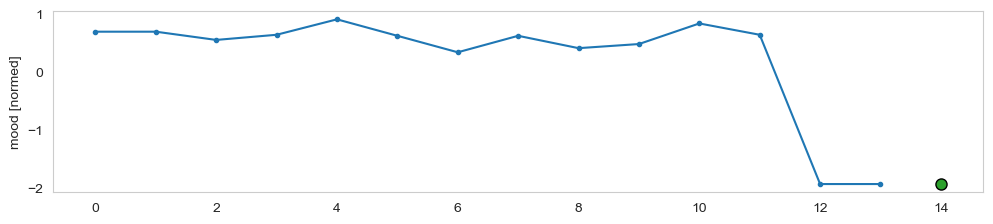

In [27]:
plot_2(test_window, lstm_model)

In [ ]:
test_window.plot(lstm_model)